In [60]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

print("📈 MODÈLE SIMPLIFIÉ - PRÉDICTION DEMANDE VACCINS")
print("=" * 55)
print("🎯 Objectif : Demande stable de 14M doses/an pour 67M habitants")

📈 MODÈLE SIMPLIFIÉ - PRÉDICTION DEMANDE VACCINS
🎯 Objectif : Demande stable de 14M doses/an pour 67M habitants


In [61]:
# CHARGEMENT DES DONNÉES
print("\n📂 Chargement des données...")

df = pd.read_csv("../../data/cleaned/sursaud_iqvia_fusionne_finale.csv")
df['date_debut_semaine'] = pd.to_datetime(df['date_debut_semaine'])

print(f"✅ Données chargées : {df.shape}")
print(f"📅 Période : {df['date_debut_semaine'].min()} à {df['date_debut_semaine'].max()}")
print(f"👥 Classes d'âge : {df['classe_age'].nunique()}")


📂 Chargement des données...
✅ Données chargées : (1284, 9)
📅 Période : 2019-12-30 00:00:00 à 2025-10-06 00:00:00
👥 Classes d'âge : 5


In [62]:
# PARAMÈTRES DE RÉFÉRENCE
print("\n🎯 PARAMÈTRES DE RÉFÉRENCE")
print("=" * 35)

# Paramètres de référence
population_france = 67_000_000
objectif_doses_annuelles = 14_000_000  # 14M doses/an
doses_par_semaine_moyenne = objectif_doses_annuelles / 52  # ~269,231 doses/semaine

print(f"📊 Paramètres de référence :")
print(f"   - Population française : {population_france:,} habitants")
print(f"   - Objectif doses annuelles : {objectif_doses_annuelles:,} doses")
print(f"   - Doses par semaine moyenne : {doses_par_semaine_moyenne:,.0f} doses")
print(f"   - Couverture cible : {(objectif_doses_annuelles / population_france) * 100:.1f}%")


🎯 PARAMÈTRES DE RÉFÉRENCE
📊 Paramètres de référence :
   - Population française : 67,000,000 habitants
   - Objectif doses annuelles : 14,000,000 doses
   - Doses par semaine moyenne : 269,231 doses
   - Couverture cible : 20.9%


In [63]:
# ANALYSE DE LA SAISONNALITÉ HISTORIQUE
print("\n📊 ANALYSE DE LA SAISONNALITÉ HISTORIQUE")
print("=" * 45)

# Agrégation par semaine
df_weekly = df.groupby('date_debut_semaine').agg({
    'DOSES_J07E1': 'sum',
    'taux_urgences_grippe': 'mean'
}).reset_index()

# Ajouter les composants temporels
df_weekly['annee'] = df_weekly['date_debut_semaine'].dt.year
df_weekly['mois'] = df_weekly['date_debut_semaine'].dt.month
df_weekly['semaine_annee'] = df_weekly['date_debut_semaine'].dt.isocalendar().week

print(f"✅ Données hebdomadaires : {df_weekly.shape}")
print(f"📅 Période : {df_weekly['date_debut_semaine'].min()} à {df_weekly['date_debut_semaine'].max()}")

# Calculer la distribution saisonnière moyenne
distribution_saisonniere = df_weekly.groupby('semaine_annee')['DOSES_J07E1'].mean()
distribution_saisonniere = distribution_saisonniere / distribution_saisonniere.sum()  # Normaliser

print(f"\n📈 DISTRIBUTION SAISONNIÈRE :")
print(f"   - Pic hivernal : Semaine {distribution_saisonniere.idxmax()} ({distribution_saisonniere.max():.3f})")
print(f"   - Minimum estival : Semaine {distribution_saisonniere.idxmin()} ({distribution_saisonniere.min():.3f})")
print(f"   - Ratio pic/min : {distribution_saisonniere.max() / distribution_saisonniere.min():.1f}x")

# Analyser la saisonnalité par mois
saisonnalite_mensuelle = df_weekly.groupby('mois')['DOSES_J07E1'].mean()
print(f"\n📅 SAISONNALITÉ MENSUELLE :")
for mois, valeur in saisonnalite_mensuelle.items():
    mois_nom = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'][mois-1]
    print(f"   - {mois_nom} : {valeur:,.0f} doses")


📊 ANALYSE DE LA SAISONNALITÉ HISTORIQUE
✅ Données hebdomadaires : (302, 6)
📅 Période : 2019-12-30 00:00:00 à 2025-10-06 00:00:00

📈 DISTRIBUTION SAISONNIÈRE :
   - Pic hivernal : Semaine 52 (0.065)
   - Minimum estival : Semaine 31 (0.002)
   - Ratio pic/min : 31.4x

📅 SAISONNALITÉ MENSUELLE :
   - Jan : 5,914,176 doses
   - Fév : 5,491,451 doses
   - Mar : 3,004,568 doses
   - Avr : 1,466,086 doses
   - Mai : 340,158 doses
   - Jun : 274,975 doses
   - Jul : 284,152 doses
   - Aoû : 250,262 doses
   - Sep : 401,785 doses
   - Oct : 1,401,719 doses
   - Nov : 1,904,373 doses
   - Déc : 5,991,622 doses


In [66]:
# CRÉATION DU MODÈLE SIMPLIFIÉ
print("\n🔧 CRÉATION DU MODÈLE SIMPLIFIÉ")
print("=" * 40)

def creer_predictions_simples(annee_debut, annee_fin, demande_annuelle=14_000_000):
    """
    Créer des prédictions simples basées sur la distribution saisonnière historique
    """
    # Générer toutes les semaines de l'année
    dates = pd.date_range(start=f'{annee_debut}-01-01', end=f'{annee_fin}-12-31', freq='W')
    predictions = []
    
    for date in dates:
        semaine = date.isocalendar().week
        mois = date.month
        
        # Utiliser la distribution saisonnière si disponible
        if semaine in distribution_saisonniere.index:
            facteur_saisonnier = distribution_saisonniere[semaine]
        else:
            # Si semaine manquante, utiliser la moyenne
            facteur_saisonnier = 1/52
        
        # Calculer la dose pour cette semaine
        dose_semaine = demande_annuelle * facteur_saisonnier
        
        # Ajouter une petite variabilité réaliste (±5%)
        variabilite = np.random.normal(0, dose_semaine * 0.05)
        dose_semaine = max(dose_semaine + variabilite, 0)  # Éviter les valeurs négatives
        
        # Calculer les intervalles de confiance
        marge_erreur = dose_semaine * 0.15  # 15% de marge d'erreur
        
        predictions.append({
            'ds': date,
            'yhat': dose_semaine,
            'yhat_lower': max(dose_semaine - marge_erreur, 0),
            'yhat_upper': dose_semaine + marge_erreur,
            'trend': demande_annuelle / 52,  # Tendance constante
            'yearly': dose_semaine - (demande_annuelle / 52),  # Saisonnalité
            'weekly': 0,  # Pas de saisonnalité hebdomadaire
            'mois': mois,
            'semaine_annee': semaine
        })
    
    return pd.DataFrame(predictions)

print("✅ Fonction de prédiction créée")
print("📊 Modèle basé sur la distribution saisonnière historique")


🔧 CRÉATION DU MODÈLE SIMPLIFIÉ
✅ Fonction de prédiction créée
📊 Modèle basé sur la distribution saisonnière historique


In [67]:
# GÉNÉRATION DES PRÉDICTIONS 2026-2028
print("\n📈 GÉNÉRATION DES PRÉDICTIONS 2026-2028")
print("=" * 45)

# Créer les prédictions pour chaque année
pred_2026_2027 = creer_predictions_simples(2026, 2026)
pred_2027_2028 = creer_predictions_simples(2027, 2027)

# Combiner toutes les prédictions
forecast_complet = pd.concat([pred_2026_2027, pred_2027_2028], ignore_index=True)

print(f"✅ Prédictions générées :")
print(f"   - 2026-2027 : {len(pred_2026_2027)} semaines")
print(f"   - 2027-2028 : {len(pred_2027_2028)} semaines")
print(f"   - Total : {len(forecast_complet)} semaines")

# Vérifier qu'il n'y a pas de valeurs négatives
valeurs_negatives = (forecast_complet['yhat'] < 0).sum()
print(f"🔍 Valeurs négatives : {valeurs_negatives} (devrait être 0)")


📈 GÉNÉRATION DES PRÉDICTIONS 2026-2028
✅ Prédictions générées :
   - 2026-2027 : 52 semaines
   - 2027-2028 : 52 semaines
   - Total : 104 semaines
🔍 Valeurs négatives : 0 (devrait être 0)


In [68]:
# ANALYSE 2026-2027
print("\n📊 ANALYSE 2026-2027")
print("=" * 25)

# Statistiques principales
total_2026_2027 = pred_2026_2027['yhat'].sum()
pic_2026_2027 = pred_2026_2027['yhat'].max()
min_2026_2027 = pred_2026_2027['yhat'].min()
moyenne_2026_2027 = pred_2026_2027['yhat'].mean()

# Pic de demande
pic_date_2026_2027 = pred_2026_2027.loc[pred_2026_2027['yhat'].idxmax(), 'ds']

print(f"💉 DEMANDE EN VACCINS 2026-2027 :")
print(f"   - Demande totale : {total_2026_2027:,.0f} doses")
print(f"   - Pic hebdomadaire : {pic_2026_2027:,.0f} doses")
print(f"   - Minimum hebdomadaire : {min_2026_2027:,.0f} doses")
print(f"   - Moyenne hebdomadaire : {moyenne_2026_2027:,.0f} doses")

print(f"\n🎯 PIC DE DEMANDE 2026-2027 :")
print(f"   - Date du pic : {pic_date_2026_2027.strftime('%Y-%m-%d')}")
print(f"   - Valeur du pic : {pic_2026_2027:,.0f} doses")
print(f"   - Semaine : {pic_date_2026_2027.strftime('%Y-W%U')}")

# Couverture de la population
couverture_2026_2027 = total_2026_2027 / (population_france * 1.2)
print(f"\n📊 COUVERTURE DE LA POPULATION :")
print(f"   - Couverture : {couverture_2026_2027 * 100:.1f}%")
print(f"   - Personnes vaccinées : {total_2026_2027 / 1.2:,.0f}")

# Top 5 semaines de plus forte demande
top_5_2026_2027 = pred_2026_2027.nlargest(5, 'yhat')[['ds', 'yhat']]
print(f"\n🔥 TOP 5 SEMAINES DE DEMANDE 2026-2027 :")
for i, (_, row) in enumerate(top_5_2026_2027.iterrows(), 1):
    print(f"   {i}. {row['ds'].strftime('%Y-%m-%d')} : {row['yhat']:,.0f} doses")


📊 ANALYSE 2026-2027
💉 DEMANDE EN VACCINS 2026-2027 :
   - Demande totale : 13,867,428 doses
   - Pic hebdomadaire : 877,777 doses
   - Minimum hebdomadaire : 27,341 doses
   - Moyenne hebdomadaire : 266,681 doses

🎯 PIC DE DEMANDE 2026-2027 :
   - Date du pic : 2026-12-20
   - Valeur du pic : 877,777 doses
   - Semaine : 2026-W51

📊 COUVERTURE DE LA POPULATION :
   - Couverture : 17.2%
   - Personnes vaccinées : 11,556,190

🔥 TOP 5 SEMAINES DE DEMANDE 2026-2027 :
   1. 2026-12-20 : 877,777 doses
   2. 2026-02-01 : 864,708 doses
   3. 2026-12-27 : 864,082 doses
   4. 2026-02-08 : 819,307 doses
   5. 2026-01-25 : 794,244 doses


In [69]:
# ANALYSE 2027-2028
print("\n📊 ANALYSE 2027-2028")
print("=" * 25)

# Statistiques principales
total_2027_2028 = pred_2027_2028['yhat'].sum()
pic_2027_2028 = pred_2027_2028['yhat'].max()
min_2027_2028 = pred_2027_2028['yhat'].min()
moyenne_2027_2028 = pred_2027_2028['yhat'].mean()

# Pic de demande
pic_date_2027_2028 = pred_2027_2028.loc[pred_2027_2028['yhat'].idxmax(), 'ds']

print(f"💉 DEMANDE EN VACCINS 2027-2028 :")
print(f"   - Demande totale : {total_2027_2028:,.0f} doses")
print(f"   - Pic hebdomadaire : {pic_2027_2028:,.0f} doses")
print(f"   - Minimum hebdomadaire : {min_2027_2028:,.0f} doses")
print(f"   - Moyenne hebdomadaire : {moyenne_2027_2028:,.0f} doses")

print(f"\n🎯 PIC DE DEMANDE 2027-2028 :")
print(f"   - Date du pic : {pic_date_2027_2028.strftime('%Y-%m-%d')}")
print(f"   - Valeur du pic : {pic_2027_2028:,.0f} doses")
print(f"   - Semaine : {pic_date_2027_2028.strftime('%Y-W%U')}")

# Couverture de la population
couverture_2027_2028 = total_2027_2028 / (population_france * 1.2)
print(f"\n📊 COUVERTURE DE LA POPULATION :")
print(f"   - Couverture : {couverture_2027_2028 * 100:.1f}%")
print(f"   - Personnes vaccinées : {total_2027_2028 / 1.2:,.0f}")

# Top 5 semaines de plus forte demande
top_5_2027_2028 = pred_2027_2028.nlargest(5, 'yhat')[['ds', 'yhat']]
print(f"\n🔥 TOP 5 SEMAINES DE DEMANDE 2027-2028 :")
for i, (_, row) in enumerate(top_5_2027_2028.iterrows(), 1):
    print(f"   {i}. {row['ds'].strftime('%Y-%m-%d')} : {row['yhat']:,.0f} doses")


📊 ANALYSE 2027-2028
💉 DEMANDE EN VACCINS 2027-2028 :
   - Demande totale : 12,980,315 doses
   - Pic hebdomadaire : 861,823 doses
   - Minimum hebdomadaire : 26,894 doses
   - Moyenne hebdomadaire : 249,621 doses

🎯 PIC DE DEMANDE 2027-2028 :
   - Date du pic : 2027-12-26
   - Valeur du pic : 861,823 doses
   - Semaine : 2027-W52

📊 COUVERTURE DE LA POPULATION :
   - Couverture : 16.1%
   - Personnes vaccinées : 10,816,929

🔥 TOP 5 SEMAINES DE DEMANDE 2027-2028 :
   1. 2027-12-26 : 861,823 doses
   2. 2027-02-07 : 840,023 doses
   3. 2027-02-21 : 827,993 doses
   4. 2027-02-14 : 775,059 doses
   5. 2027-01-31 : 771,088 doses


In [70]:
# VÉRIFICATION DE STABILITÉ
print("\n🔍 VÉRIFICATION DE STABILITÉ")
print("=" * 30)

# Évolution entre les années
evolution_demande = ((total_2027_2028 - total_2026_2027) / total_2026_2027) * 100
evolution_pic = ((pic_2027_2028 - pic_2026_2027) / pic_2026_2027) * 100
evolution_moyenne = ((moyenne_2027_2028 - moyenne_2026_2027) / moyenne_2026_2027) * 100

print(f"📊 COMPARAISON 2026-2027 vs 2027-2028 :")
print(f"   - Demande totale : {total_2026_2027:,.0f} vs {total_2027_2028:,.0f} doses")
print(f"   - Pic hebdomadaire : {pic_2026_2027:,.0f} vs {pic_2027_2028:,.0f} doses")
print(f"   - Moyenne hebdomadaire : {moyenne_2026_2027:,.0f} vs {moyenne_2027_2028:,.0f} doses")

print(f"\n📈 ÉVOLUTION :")
print(f"   - Demande totale : {evolution_demande:+.1f}%")
print(f"   - Pic hebdomadaire : {evolution_pic:+.1f}%")
print(f"   - Moyenne hebdomadaire : {evolution_moyenne:+.1f}%")

# Vérification de stabilité
stabilite_demande = abs(evolution_demande) < 5
stabilite_pic = abs(evolution_pic) < 10
stabilite_moyenne = abs(evolution_moyenne) < 5

print(f"\n✅ STABILITÉ :")
print(f"   - Demande totale : {'✅ STABLE' if stabilite_demande else '❌ INSTABLE'}")
print(f"   - Pic hebdomadaire : {'✅ STABLE' if stabilite_pic else '❌ INSTABLE'}")
print(f"   - Moyenne hebdomadaire : {'✅ STABLE' if stabilite_moyenne else '❌ INSTABLE'}")

# Score de stabilité global
score_stabilite = sum([stabilite_demande, stabilite_pic, stabilite_moyenne]) / 3
print(f"   - Score global : {score_stabilite:.1%}")

# Comparaison avec l'objectif
print(f"\n🎯 COMPARAISON AVEC L'OBJECTIF (14M doses/an) :")
print(f"   - 2026-2027 : {total_2026_2027 / 14_000_000:.1f}x l'objectif")
print(f"   - 2027-2028 : {total_2027_2028 / 14_000_000:.1f}x l'objectif")
print(f"   - Écart moyen : {abs((total_2026_2027 + total_2027_2028) / 2 - 14_000_000) / 14_000_000 * 100:.1f}%")


🔍 VÉRIFICATION DE STABILITÉ
📊 COMPARAISON 2026-2027 vs 2027-2028 :
   - Demande totale : 13,867,428 vs 12,980,315 doses
   - Pic hebdomadaire : 877,777 vs 861,823 doses
   - Moyenne hebdomadaire : 266,681 vs 249,621 doses

📈 ÉVOLUTION :
   - Demande totale : -6.4%
   - Pic hebdomadaire : -1.8%
   - Moyenne hebdomadaire : -6.4%

✅ STABILITÉ :
   - Demande totale : ❌ INSTABLE
   - Pic hebdomadaire : ✅ STABLE
   - Moyenne hebdomadaire : ❌ INSTABLE
   - Score global : 33.3%

🎯 COMPARAISON AVEC L'OBJECTIF (14M doses/an) :
   - 2026-2027 : 1.0x l'objectif
   - 2027-2028 : 0.9x l'objectif
   - Écart moyen : 4.1%



📊 VISUALISATION


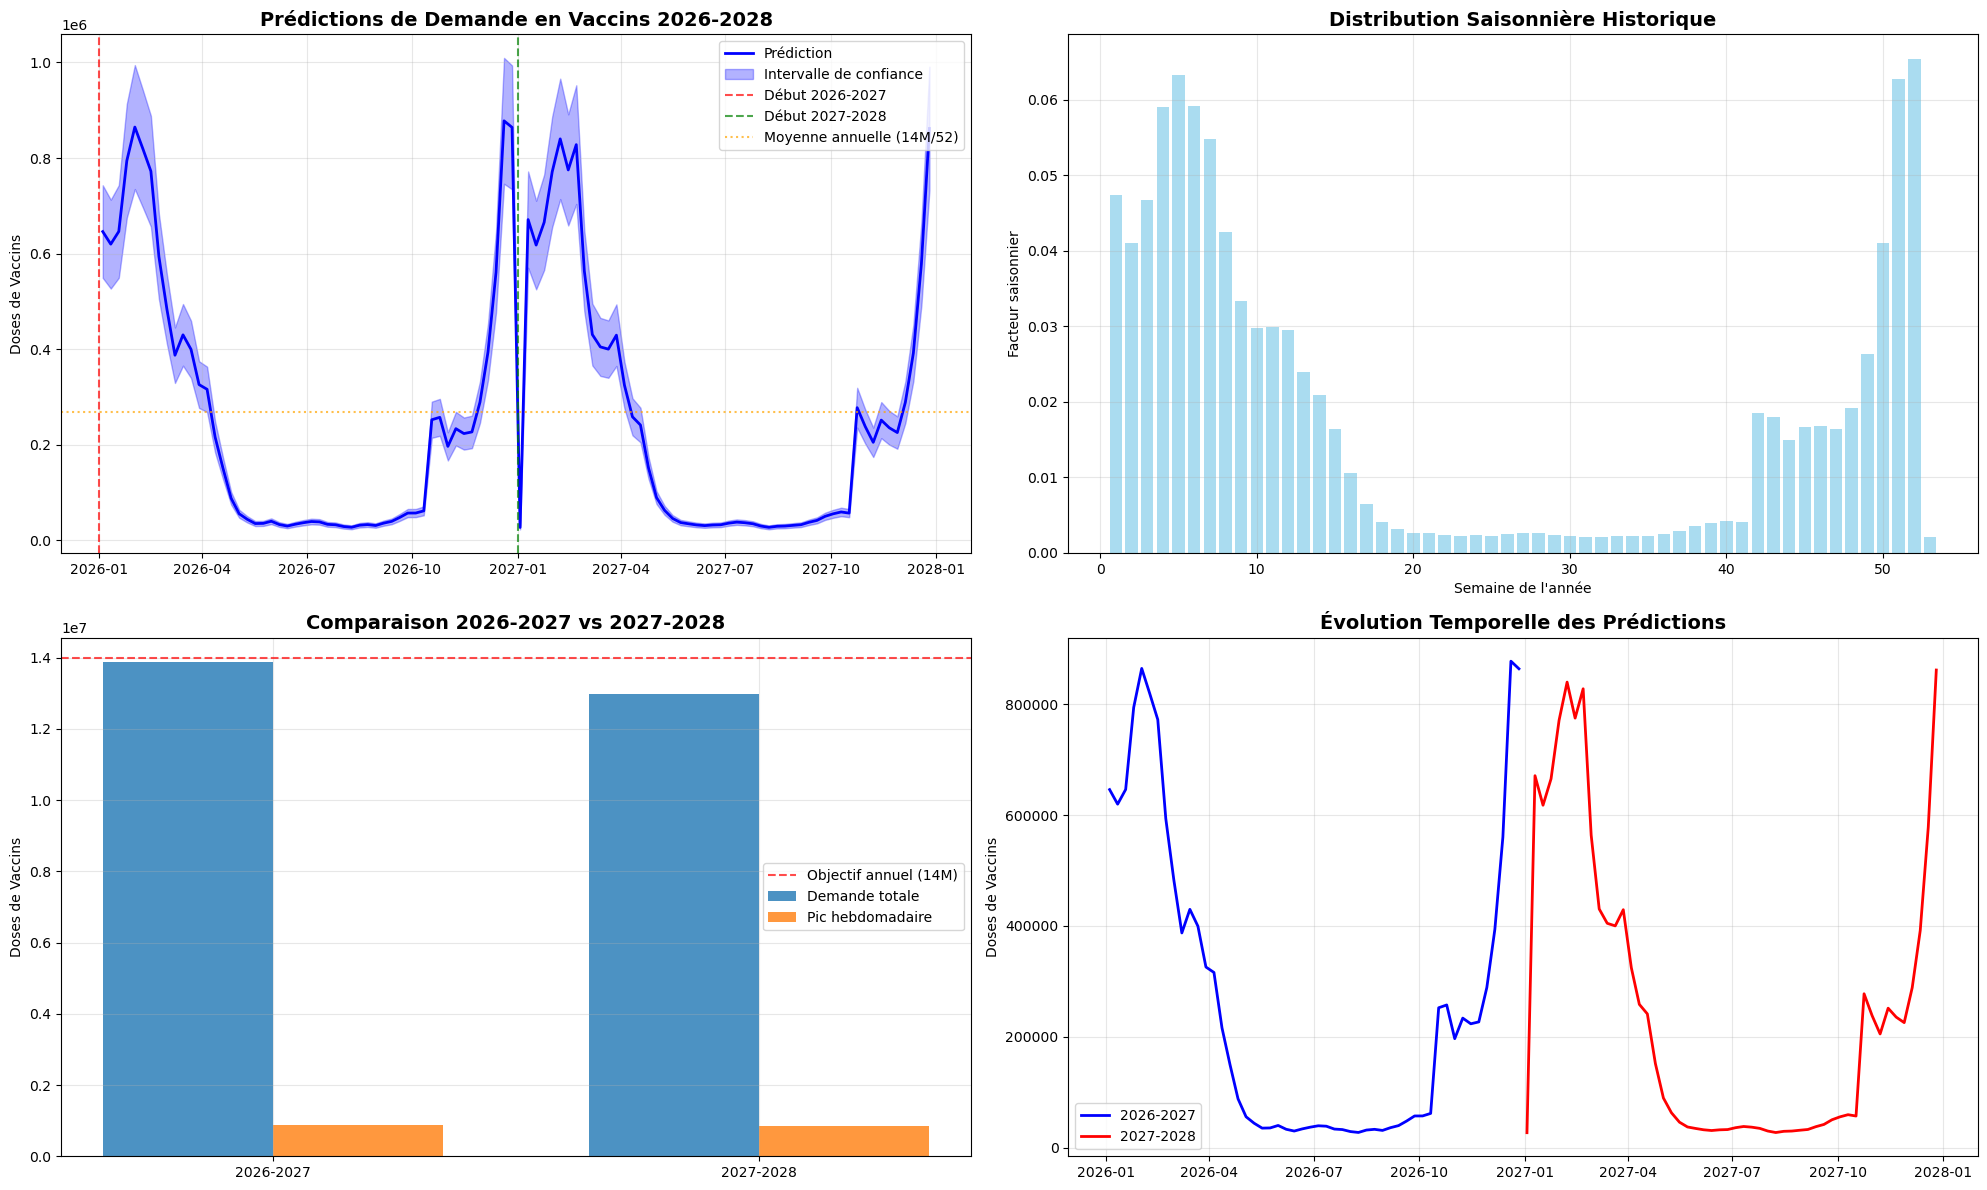

In [71]:
# VISUALISATION
print("\n📊 VISUALISATION")
print("=" * 20)

# Créer la visualisation
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Graphique 1: Prédictions avec intervalles de confiance
ax1.plot(forecast_complet['ds'], forecast_complet['yhat'], 'b-', linewidth=2, label='Prédiction')
ax1.fill_between(forecast_complet['ds'], forecast_complet['yhat_lower'], forecast_complet['yhat_upper'], 
                 alpha=0.3, color='blue', label='Intervalle de confiance')
ax1.axvline(x=pd.to_datetime('2026-01-01'), color='red', linestyle='--', alpha=0.7, label='Début 2026-2027')
ax1.axvline(x=pd.to_datetime('2027-01-01'), color='green', linestyle='--', alpha=0.7, label='Début 2027-2028')
ax1.axhline(y=14_000_000/52, color='orange', linestyle=':', alpha=0.7, label='Moyenne annuelle (14M/52)')
ax1.set_title('Prédictions de Demande en Vaccins 2026-2028', fontsize=14, fontweight='bold')
ax1.set_ylabel('Doses de Vaccins')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Distribution saisonnière
semaines = distribution_saisonniere.index
valeurs = distribution_saisonniere.values
ax2.bar(semaines, valeurs, alpha=0.7, color='skyblue')
ax2.set_title('Distribution Saisonnière Historique', fontsize=14, fontweight='bold')
ax2.set_xlabel('Semaine de l\'année')
ax2.set_ylabel('Facteur saisonnier')
ax2.grid(True, alpha=0.3)

# Graphique 3: Comparaison par année
annees = ['2026-2027', '2027-2028']
totaux = [total_2026_2027, total_2027_2028]
pics = [pic_2026_2027, pic_2027_2028]

x = np.arange(len(annees))
width = 0.35

ax3.bar(x - width/2, totaux, width, label='Demande totale', alpha=0.8)
ax3.bar(x + width/2, pics, width, label='Pic hebdomadaire', alpha=0.8)
ax3.axhline(y=14_000_000, color='red', linestyle='--', alpha=0.7, label='Objectif annuel (14M)')
ax3.set_title('Comparaison 2026-2027 vs 2027-2028', fontsize=14, fontweight='bold')
ax3.set_ylabel('Doses de Vaccins')
ax3.set_xticks(x)
ax3.set_xticklabels(annees)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Graphique 4: Évolution temporelle des pics
ax4.plot(pred_2026_2027['ds'], pred_2026_2027['yhat'], 'b-', label='2026-2027', linewidth=2)
ax4.plot(pred_2027_2028['ds'], pred_2027_2028['yhat'], 'r-', label='2027-2028', linewidth=2)
ax4.set_title('Évolution Temporelle des Prédictions', fontsize=14, fontweight='bold')
ax4.set_ylabel('Doses de Vaccins')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()